# Training d'un agent Othello

## Importation des modules

In [3]:
from Board import Board, Signal
from Agent import Memory, Model, encode_action, game_over_from_signal

import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

from PIL import Image, ImageDraw
from IPython.display import display # to display images

import math
import random
import numpy as np

%matplotlib inline

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Définition d'un mmodèle de réseau de neurones

In [4]:
class Model(nn.Module):

    def __init__(self):
        super(Model, self).__init__()
        # Input (2, 8, 8,)
        # Output (65,)
        self.input_layer = nn.Linear(128, 128)
        self.hidden_layer_1 = nn.Linear(128, 128)
        self.hidden_layer_2 = nn.Linear(128, 128)
        self.hidden_layer_3 = nn.Linear(128, 128)
        self.hidden_layer_4 = nn.Linear(128, 128)
        self.hidden_layer_5 = nn.Linear(128, 128)
        # self.hidden_layer_6 = nn.Linear(128, 128)
        # self.hidden_layer_7 = nn.Linear(128, 128)
        # self.hidden_layer_8 = nn.Linear(128, 128)
        # self.hidden_layer_9 = nn.Linear(128, 128)
        # self.hidden_layer_10 = nn.Linear(128, 128)
        # self.hidden_layer_11 = nn.Linear(128, 128)
        # self.input_layer = nn.Conv2d(2, 128, 3, padding=1)
        # self.hidden_layer_1 = nn.Conv2d(128, 128, 3, padding=1)
        # self.hidden_layer_2 = nn.Conv2d(128, 128, 3, padding=1)
        # self.hidden_layer_3 = nn.Conv2d(128, 128, 3, padding=1)
        # self.hidden_layer_4 = nn.Conv2d(128, 128, 3, padding=1)
        # self.hidden_layer_5 = nn.Linear(128*8*8, 128*8)
        # self.hidden_layer_6 = nn.Linear(128*8, 128)
        self.output_layer = nn.Linear(128, 65)

    def forward(self, x):
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.input_layer(x))
        x = F.relu(self.hidden_layer_1(x))
        x = F.relu(self.hidden_layer_2(x))
        x = F.relu(self.hidden_layer_3(x))
        x = F.relu(self.hidden_layer_4(x))
        x = F.relu(self.hidden_layer_5(x))
        # x = F.relu(self.hidden_layer_6(x))
        # x = F.relu(self.hidden_layer_7(x))
        # x = F.relu(self.hidden_layer_8(x))
        # x = F.relu(self.hidden_layer_9(x))
        # x = F.relu(self.hidden_layer_10(x))
        # x = F.relu(self.hidden_layer_11(x))
        output = self.output_layer(x)
        return output
    
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [5]:
def reward_from_signal(signal: Signal, board: Board):
    reward = 0
    if signal is Signal.ILLEGAL_MOVE:
            reward = -1
    elif signal is Signal.VALID_MOVE:
        reward = 1
    else: # Game over
        winner = board.get_winner()
        if winner == 1: # White
            reward = 100
        elif winner == -1: # Black
            reward = -100
        else: # Draw
            reward = -50
    return reward

def game_over_from_signal(signal: Signal, board: Board):
    game_over = signal in [Signal.GAME_OVER, Signal.ILLEGAL_MOVE]
    return game_over

## Méthode de visualisation des q_matrix

In [6]:
def render_q(q: list):
    dimension = (128, 128)
    max_negative = np.min([np.min(q), 0])
    max_positive = np.max([np.max(q), 0])
    image = Image.new('RGBA', dimension, (255,255,225,255))
    draw = ImageDraw.Draw(image)
    y = 0
    i = 0
    for l in range(8):
        x = 0
        for c in range(8):
            xy = [(x + 1, y + 1), (x + 14, y + 14)]
            r = q[i]
            if r > 0:
                # a = min(255, max(0, int(r * 1 * 255)))
                a = int(r / max_positive * 255)
                color = (0,0,255,a)
                draw.rectangle(xy, fill=color)
            elif r < 0:
                # a = min(255, max(0, int(-r * 1 * 255)))
                a = int(r / max_negative * 255)
                color = (255,0,0,a)
                draw.rectangle(xy, fill=color)
            x += 16
            i += 1
        y += 16
    display(image)

## Premiere étape : apprentissage d'un seul coup

Q_matrix of initial state, before training:


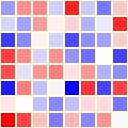

Target Q matrix:


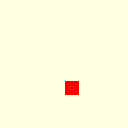

Q_matrix of initial state, after training:


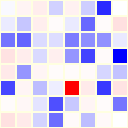

In [106]:
# New model
board = Board()
model = Model()
learning_rate = 0.3
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# Get initial state from the board
initial_s, signal = board.reset()
initial_s = torch.tensor(initial_s, dtype=torch.float).unsqueeze(0)

# Predict an action
a_scores = model(initial_s)
a = torch.argmax(a_scores).item()
encoded_a = encode_action(a)

# Perform the action in the game
s, signal = board.step(encoded_a)
next_s = torch.tensor(s, dtype=torch.float).unsqueeze(0)

# Process the signal
r = reward_from_signal(signal, board)
done = game_over_from_signal(signal, board)

# Q Learning
target_q = torch.zeros((65,), dtype=torch.float)

# Add the reward and action
target_q[a] = r

# Render model before the training
print("Q_matrix of initial state, before training:")
q_pred = model(torch.tensor(initial_s, dtype=torch.float))
render_q(q_pred.tolist()[0])

# Toggle on train mode
model.train()

for i in range(16):
    # Compute loss on the difference between model output and target_q
    q_pred = model(torch.tensor(initial_s, dtype=torch.float))
    loss = criterion(torch.tensor(target_q, dtype=torch.float), q_pred)

    # Let the optimizer do the backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

print("Target Q matrix:")
render_q(target_q.tolist())

# Render model after the training
print("Q_matrix of initial state, after training:")
q_pred = model(torch.tensor(initial_s, dtype=torch.float))
render_q(q_pred.tolist()[0])

## Deuxième étape : apprentissage du premier état avec historique

Q_matrix of initial state, before training:


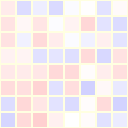

Target Q matrix:


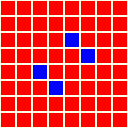

Q_matrix of initial state, after training:


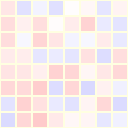

In [18]:
# New model
board = Board()
model = Model()
learning_rate = 0.3
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# Render model before the training
print("Q_matrix of initial state, before training:")
q_pred = model(torch.tensor(initial_s, dtype=torch.float))
render_q(q_pred.tolist()[0])

# (Action, Reward) container for each action
history = []

# Populating the history with every possible move
for i_action in range(65):
    # Reset the board
    board.reset()

    # Predict an action
    a = i_action
    encoded_a = encode_action(a)

    # Perform the action in the game
    s, signal = board.step(encoded_a)

    # Process the signal
    r = reward_from_signal(signal, board)

    # Add the record to history
    history.append((a, r))

# Q Learning matrix for the initial state
target_q = torch.zeros((65,), dtype=torch.float)

# Add the reward and action for each game in history
# NOTE: ça overwrite si y'a plusieurs valeurs
for (a, r) in history:
    target_q[a] = r

print("Target Q matrix:")
render_q(target_q.tolist())

# Toggle on train mode
model.train()

for i_batch in range(1):
    # Compute loss on the difference between model output and target_q
    q_pred = model(torch.tensor(initial_s, dtype=torch.float))
    loss = criterion(torch.tensor(target_q, dtype=torch.float), q_pred)

    # Let the optimizer do the backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Render model after the training
print(f"Q_matrix of initial state, after training:")
q_pred = model(torch.tensor(initial_s, dtype=torch.float))
render_q(q_pred.tolist()[0])

## Troisième étape : à combien de coup est-ce que l'agent "comprend" le premier état ?

Target Q matrix: step 1


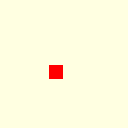

Q_matrix of initial state, after training: step 1


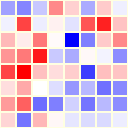

Target Q matrix: step 11


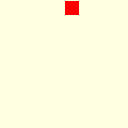

Q_matrix of initial state, after training: step 11


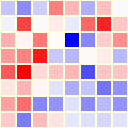

Target Q matrix: step 21


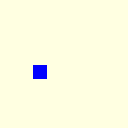

Q_matrix of initial state, after training: step 21


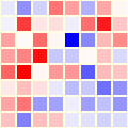

Target Q matrix: step 31


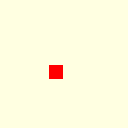

Q_matrix of initial state, after training: step 31


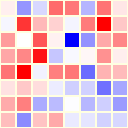

Target Q matrix: step 41


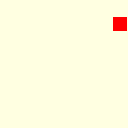

Q_matrix of initial state, after training: step 41


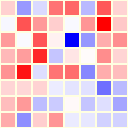

Target Q matrix: step 51


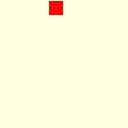

Q_matrix of initial state, after training: step 51


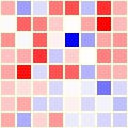

Target Q matrix: step 61


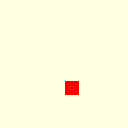

Q_matrix of initial state, after training: step 61


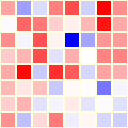

Target Q matrix: step 71


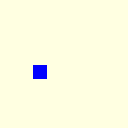

Q_matrix of initial state, after training: step 71


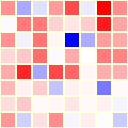

Target Q matrix: step 81


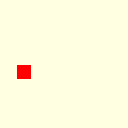

Q_matrix of initial state, after training: step 81


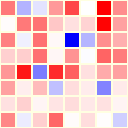

Target Q matrix: step 91


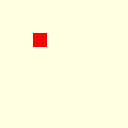

Q_matrix of initial state, after training: step 91


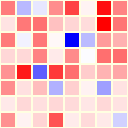

Target Q matrix: step 101


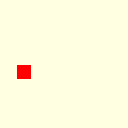

Q_matrix of initial state, after training: step 101


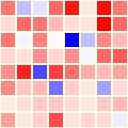

Target Q matrix: step 111


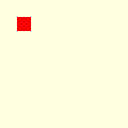

Q_matrix of initial state, after training: step 111


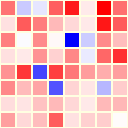

Target Q matrix: step 121


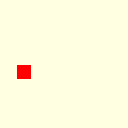

Q_matrix of initial state, after training: step 121


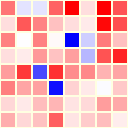

Target Q matrix: step 131


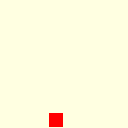

Q_matrix of initial state, after training: step 131


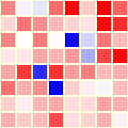

Target Q matrix: step 141


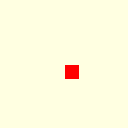

Q_matrix of initial state, after training: step 141


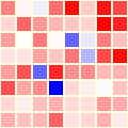

Target Q matrix: step 151


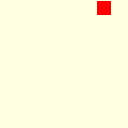

Q_matrix of initial state, after training: step 151


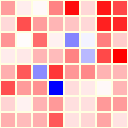

Target Q matrix: step 161


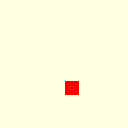

Q_matrix of initial state, after training: step 161


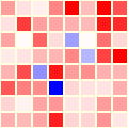

Target Q matrix: step 171


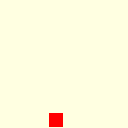

Q_matrix of initial state, after training: step 171


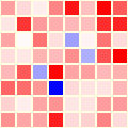

Target Q matrix: step 181


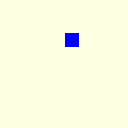

Q_matrix of initial state, after training: step 181


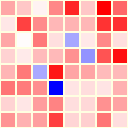

Target Q matrix: step 191


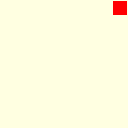

Q_matrix of initial state, after training: step 191


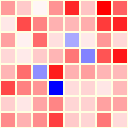

Target Q matrix: step 201


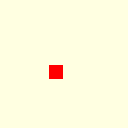

Q_matrix of initial state, after training: step 201


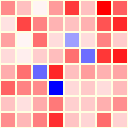

Target Q matrix: step 211


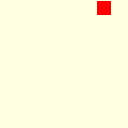

Q_matrix of initial state, after training: step 211


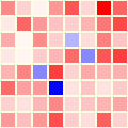

Target Q matrix: step 221


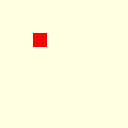

Q_matrix of initial state, after training: step 221


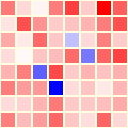

In [25]:
# New model
board = Board()
model = Model()
learning_rate = 0.3
batch_size = 32
n_epochs = 256 # On aura pas joué tous les coups mais OK
max_history = 64
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# (Action, Reward) container for each action
history = []

# Populating the history with every possible move
for i_epoch in range(n_epochs):
    # Reset the board
    initial_s, _ = board.reset()
    initial_s = torch.tensor(initial_s, dtype=torch.float).unsqueeze(0)

    # Play a random action
    a = torch.randint(0, 65, (1,)).item()
    encoded_a = encode_action(a)

    # Perform the action in the game
    s, signal = board.step(encoded_a)

    # Process the signal
    r = reward_from_signal(signal, board)

    # Add the record to history
    history.append((a, r))

    # Continue playing if we don't have enough moves to learn in the history
    if len(history) <= batch_size:
        continue

    # Keep history the wanted size removing first element in list
        if len(history) > max_history:
            history.pop(0)

    # Add the reward and action for each game in history
    # NOTE: ça overwrite si y'a plusieurs valeurs, donc batch_size devrait être < 65
    # TODO: moyenne des valeurs ? pas d'overwrite ?
    targets = torch.zeros(batch_size, 65)
    inputs = torch.zeros(batch_size, 2, 8, 8)
    for i_batch, (a, r) in enumerate(random.sample(history, batch_size)):
        # Q Learning matrix for the initial state
        # NOTE: Je pense qu'il faudrait partir de la prédiction du modèle
        # et y ajouter les rewards, les cases où il y a 0 peuvent peut-être
        # poser problème
        target_q = torch.zeros((65,), dtype=torch.float)#model(initial_s).view(-1)# torch.zeros((65,), dtype=torch.float)
        target_q[a] = r
        targets[i_batch] = target_q
        inputs[i_batch] = initial_s

    # Toggle on train mode
    model.train()

    # for i_batch in range(4):
    # Compute loss on the difference between model output and target_q
    inputs = torch.tensor(inputs)
    targets = torch.tensor(targets)
    q_pred = model(inputs)        
    q_pred = torch.clip(q_pred, -3, 3)
    loss = criterion(targets, q_pred)

    # Let the optimizer do the backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (i_epoch - batch_size) % 10 == 0:
        print(f"Target Q matrix: step {i_epoch - batch_size + 1}")
        render_q(target_q.tolist())

        print(f"Q_matrix of initial state, after training: step {i_epoch - batch_size + 1}")
        q_pred = model(torch.tensor(initial_s, dtype=torch.float))
        render_q(q_pred.tolist()[0])

## Etape 4 : mouvements futurs et epsilon

In [1]:
# New model
board = Board()
test_board = Board()
model = Model()
model.to(device)
epsilon = [0.9]
epsilon_start = 1
epsilon_end = 0.01
epsilon_decay = 512
learning_rate = 0.001
gamma = 0.9
batch_size = 32
max_history = 1024
n_epochs = 4096*2
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# (State, Action, NextState, Reward, Done) container for each action
history = []
mean_length = []

# Populating the history with every possible move
for i_epoch in range(n_epochs):
    # Reset the board
    done = False
    s, signal = board.reset()
    s = torch.tensor(s, dtype=torch.float).unsqueeze(0)

    # Play a full game
    length = 0
    total_r = 0
    while not done:

        #========================== ACTION
        # Play a random action or ask the model
        a = 0
        if length > len(epsilon):
            epsilon.append(epsilon_start)
        else:
            epsilon[length] = epsilon_end + (epsilon_start - epsilon_end) * math.exp(-1. * i_epoch / epsilon_decay)
        if np.random.rand() <= epsilon[length]:
            a = torch.randint(0, 65, (1,)).item()
        else:
            a_scores = model(s.to(device))
            a = torch.argmax(a_scores).item()
        encoded_a = encode_action(a)

        # Perform the action in the game
        n_s, signal = board.step(encoded_a)
        n_s = torch.tensor(n_s, dtype=torch.float).unsqueeze(0)

        # Process the signal
        r = reward_from_signal(signal, board) + length / 2
        total_r += r
        done = game_over_from_signal(signal, board)
        #-------------------------- ACTION

        #========================== BLACK SAMPLE MOVE
        black_action = board.sample()
        n_s, signal = board.step(black_action)
        n_s = torch.tensor(n_s, dtype=torch.float).unsqueeze(0)
        #-------------------------- BLACK SAMPLE MOVE

        #========================== HISTORY
        # Add the record to history
        for i_history in range(length):
            history.append((s, a, r, n_s, done))
        
        # Update current state
        s = n_s

        # Continue playing if we don't have enough moves to learn in the history
        if len(history) <= batch_size:
            continue

        # Keep history the wanted size removing first element in list
        while len(history) > max_history:
            history.pop(0)
        #-------------------------- HISTORY

        #========================== Q LEARNING
        # Q Learning matrix for the initial state
        targets = torch.zeros(batch_size, 65)
        inputs = torch.zeros(batch_size, 2, 8, 8)
        i_batch = 0
        samples = random.sample(history, batch_size - 1) + [history[-1]]
        for i_batch, (s_, a_, r_, n_s_, done_) in enumerate(samples):
            # Build bellman equation for the Q function
            inputs[i_batch] = s_
            targets[i_batch] = model(s_.to(device)).view(-1) # torch.zeros((65,), dtype=torch.float)
            Q_sa = model(n_s_.to(device))

            # Emplace reward
            if done_:
                targets[i_batch, a_] = r_
            else:
                targets[i_batch, a_] = r_ + gamma * torch.max(Q_sa)


        # Compute loss on the difference between model output and target_q
        model.train()
        q_pred = model(inputs.to(device))        
        targets = torch.clip(targets, -3, 3)
        loss = criterion(targets.to(device), q_pred)

        # Let the optimizer do the backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update length
        length += 1
    
    if len(mean_length) <= 50:
        mean_length.append(length)
    else:
        mean_length.pop(0)
    print(f"Epoch {i_epoch} \t reward: {total_r} \t length {length} \t mean_length {int(np.mean(mean_length) * 100)/100} \t epsilon {np.floor(epsilon*100)/100}")
    
    # Display matrixes
    if i_epoch > batch_size and (i_epoch - batch_size) % 100 == 1:
        print(f"Q_matrix of initial state, after training: step {i_epoch - batch_size}")
        s, signal = test_board.reset()
        s = torch.tensor(s, dtype=torch.float).unsqueeze(0)
        a_scores = model(s.to(device))
        q1 = a_scores.to("cpu")
        render_q(q1.tolist()[0])
        a = torch.argmax(a_scores).item()
        encoded_a = encode_action(a)
        n_s, signal = test_board.step(encoded_a)
        if not game_over_from_signal(signal, test_board):
            black_action = test_board.sample()
            n_s, signal = test_board.step(black_action)
            n_s = torch.tensor(n_s, dtype=torch.float).unsqueeze(0)
            a_scores = model(n_s.to(device))
            q2 = a_scores.to("cpu")
            render_q(q2.tolist()[0])
            render_q((q2 - q1).tolist()[0])
            a = torch.argmax(a_scores).item()
            encoded_a = encode_action(a)
        play_one_game(model, render=False)

NameError: name 'Board' is not defined

In [17]:
torch.save(model.state_dict(), "model.save")


In [7]:
model = Model()
model.load_state_dict(torch.load("model.save"))
model.eval()
model.to(device)

Model(
  (input_layer): Conv2d(2, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (hidden_layer_1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (hidden_layer_21): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (hidden_layer_3): Linear(in_features=8192, out_features=1024, bias=True)
  (hidden_layer_4): Linear(in_features=1024, out_features=128, bias=True)
  (output_layer): Linear(in_features=128, out_features=65, bias=True)
)

In [8]:
def play_one_game(model, render=False):
    board = Board()
    s, sig = board.reset()
    board.render()
    s = torch.tensor(s, dtype=torch.float).unsqueeze(0)
    count = 0
    while True:
        # White moves
        count += 1
        Q = model(s.to(device))
        iQmax = torch.argmax(Q).item()
        a = encode_action(iQmax)
        print(f"White {count}:\t{a}")
        s, sig = board.step(a)
        print(f"Res:\t{sig}")
        if render:
            board.render()
        s = torch.tensor(s, dtype=torch.float).unsqueeze(0)
        if game_over_from_signal(sig, board):
            break
        # Black moves
        a = board.sample()
        print(f"Black {count}:\t{a}")
        s, sig = board.step(a)
        print(f"Res:\t{sig}")
        if render:
            board.render()
        s = torch.tensor(s, dtype=torch.float).unsqueeze(0)
        if game_over_from_signal(sig, board):
            break